In [1]:
import numpy as np
import matplotlib.pyplot as plt
from camutils import Camera, triangulate, makerotation, calibratePose
import pickle
from visutils import showPerspective
import matplotlib.patches as patches 
from mpl_toolkits.mplot3d import Axes3D

import cv2
import scipy

import trimesh

%matplotlib inline

In [2]:
plt.rcParams['figure.figsize'] = [15,15]

### Retrieve Camera parameter

In [3]:
import os.path
if os.path.exists('./camera.pickle'):
    with open('camera.pickle','rb') as f:
        o = pickle.load(f)
        (camL,camR) = o['camL'], o['camR']
else:
    # load in the intrinsic camera parameters from 'calibration.pickle'
    o = np.load("calibration.pickle", allow_pickle=True)
    fx, fy, cx, cy, dist = o['fx'], o['fy'], o['cx'], o['cy'], o['dist']

    # create Camera objects representing the left and right cameras
    # use the known intrinsic parameters you loaded in.
    focal =( fx + fy) / 2
    c = np.array([cx, cy]).reshape((2, 1))

    camL = Camera(focal, c, makerotation(0, 0, 0), np.zeros((3, 1)))
    camR = Camera(focal, c, makerotation(0, 0, 0), np.zeros((3, 1)))

    # load in the left and right images and find the coordinates of
    # the chessboard corners using OpenCV
    imgL = plt.imread('./calib_jpg_u/frame_C0_01.jpg')
    ret, cornersL = cv2.findChessboardCorners(imgL, (8,6), None)
    pts2L = cornersL.squeeze().T

    imgR = plt.imread('./calib_jpg_u/frame_C1_01.jpg')
    ret, cornersR = cv2.findChessboardCorners(imgR, (8,6), None)
    pts2R = cornersR.squeeze().T

    # generate the known 3D point coordinates of points on the checkerboard in cm
    pts3 = np.zeros((3,6*8))
    yy,xx = np.meshgrid(np.arange(8),np.arange(6))
    pts3[0,:] = 2.8*xx.reshape(1,-1)
    pts3[1,:] = 2.8*yy.reshape(1,-1)

    # run calibration
    params_init = np.array([0,0,0,0,0,-2])
    camL = calibratePose(pts3, pts2L, camL, params_init)
    camR = calibratePose(pts3, pts2R, camR, params_init)

    camera = {}
    camera["camL"] = camL
    camera["camR"] = camR
    with open('camera.pickle', 'wb') as f:
        pickle.dump(camera, f)

### Testing code from A4 

In [4]:
def generate_pairs(start):
    def pad(n):
        s = str(n)
        if len(s) == 1:
            s = '0' + s
        return s + '.png'

    p = []
    for i in range(0, 40, 2):
        p.append((pad(i), pad(i + 1)))
    return p[start // 2:start // 2 + 10]

def decode(imprefix,start,threshold):
    nbits = 10

    pairs = generate_pairs(start)
    shape = plt.imread(imprefix + pairs[0][0]).shape

    # initialize values
    code = np.zeros((shape[0], shape[1]))
    mask = np.ones((shape[0], shape[1]))

    # don't forget to convert images to grayscale / float after loading them in
    previous = None
    for index, (p1, p2) in enumerate(pairs):
        img1 = plt.imread(imprefix + p1)
        if img1.dtype == np.uint8:
            img1 = img1.astype(float) / 256
        if len(img1.shape) == 3:
            img1 = np.mean(img1, axis=2) 

        img2 = plt.imread(imprefix + p2)
        if (img2.dtype == np.uint8):
            img2 = img2.astype(float) / 256
        if len(img2.shape) == 3:
            img2 = np.mean(img2, axis=2) 

        # check recovered image and calculate the code
        recover = (img1 > img2).astype(int)
        if index == 0:
            previous = recover
        else:
            previous = np.logical_xor(previous, recover).astype(int)
        code += previous * np.power(2, 9 - index)

        # check threshold
        decodable = (np.abs(img1 - img2) > threshold).astype(int)
        mask = np.logical_and(mask, decodable)
 
    return code,mask

In [5]:
def reconstruct(path, threshold, camL,camR):
    """
    Parameters
    ----------
    imprefixL, imprefixR : str
        Image prefixes for the coded images from the left and right camera
        
    threshold : float
        Threshold to determine if a bit is decodeable
   
    camL,camR : Camera
        Calibration info for the left and right cameras
        
    Returns
    -------
    pts2L,pts2R : 2D numpy.array (dtype=float)
        The 2D pixel coordinates of the matched pixels in the left and right
        image stored in arrays of shape 2xN
        
    pts3 : 2D numpy.array (dtype=float)
        Triangulated 3D coordinates stored in an array of shape 3xN
    """
    # Extract manny by foreground - background    
    left_background =  plt.imread(path + "/color_C0_00.png")
    left_manny =  plt.imread(path + "/color_C0_01.png")
    left_manny = left_manny - left_background
    left_manny = np.where(left_manny > 0, left_manny, 0)
    left_manny_mask = left_manny > 0.05
    left_manny_mask = np.any(left_manny_mask, axis=2)
    
    right_background = plt.imread(path + "/color_C1_00.png")
    right_manny = plt.imread(path + "/color_C1_01.png")
    right_manny = right_manny - right_background
    right_manny = np.where(right_manny > 0, right_manny, 0)
    right_manny_mask = right_manny > 0.05
    right_manny_mask = np.any(right_manny_mask, axis=2)
    
    # Decode the H and V coordinates for the two views
    h_codeL, h_maskL = decode(path + "frame_C0_", 0, threshold)
    v_codeL, v_maskL = decode(path + "frame_C0_", 20, threshold)
    h_codeR, h_maskR = decode(path + "frame_C1_", 0, threshold)
    v_codeR, v_maskR = decode(path + "frame_C1_", 20, threshold)

    # Construct the combined 20 bit code C = H + 1024*V and mask for each view
    maskL = np.logical_and(left_manny_mask, np.logical_and(h_maskL, v_maskL))
    maskR = np.logical_and(right_manny_mask, np.logical_and(h_maskR, v_maskR))
    
#     plt.imshow(maskL)
#     plt.show()
#     plt.imshow(maskR)
#     plt.show()

    C_L = np.where(maskL == 1, h_codeL + 1024 * v_codeL, np.nan)
    C_R = np.where(maskR == 1, h_codeR + 1024 * v_codeR, np.nan)
    
    # Find the indices of pixels in the left and right code image that 
    # have matching codes. If there are multiple matches, just
    # choose one arbitrarily.
    values, matchL, matchR = np.intersect1d(C_L, C_R, return_indices=True)
    
    # Let CL and CR be the flattened arrays of codes for the left and right view
    # Suppose you have computed arrays of indices matchL and matchR so that 
    # CL[matchL[i]] == CR[matchR[i]] for all i.  The code below gives one approach
    # to generating the corresponding pixel coordinates for the matched pixels.
    C_L = C_L.flatten()
    C_R = C_R.flatten()
    assert((C_L[matchL] == C_R[matchR]).all())
    
    h, w = h_codeL.shape
    
    xx,yy = np.meshgrid(range(w),range(h))
    xx = np.reshape(xx,(-1,1))
    yy = np.reshape(yy,(-1,1))
    pts2R = np.concatenate((xx[matchR].T,yy[matchR].T),axis=0)
    pts2L = np.concatenate((xx[matchL].T,yy[matchL].T),axis=0)

    # Now triangulate the points
    pts3 = triangulate(pts2L, camL, pts2R, camR)
    
    # extract the color
    left_manny = plt.imread(path + "/color_C0_01.png")
    color = left_manny[pts2L[1,:], pts2L[0,:], :].T
    
    return pts2L, pts2R, pts3, color

[-9.829567226336227, 24.143979340800136, 4.894100699586025, 17.435736999919456, -22.261571095874654, -9.791679361183018]


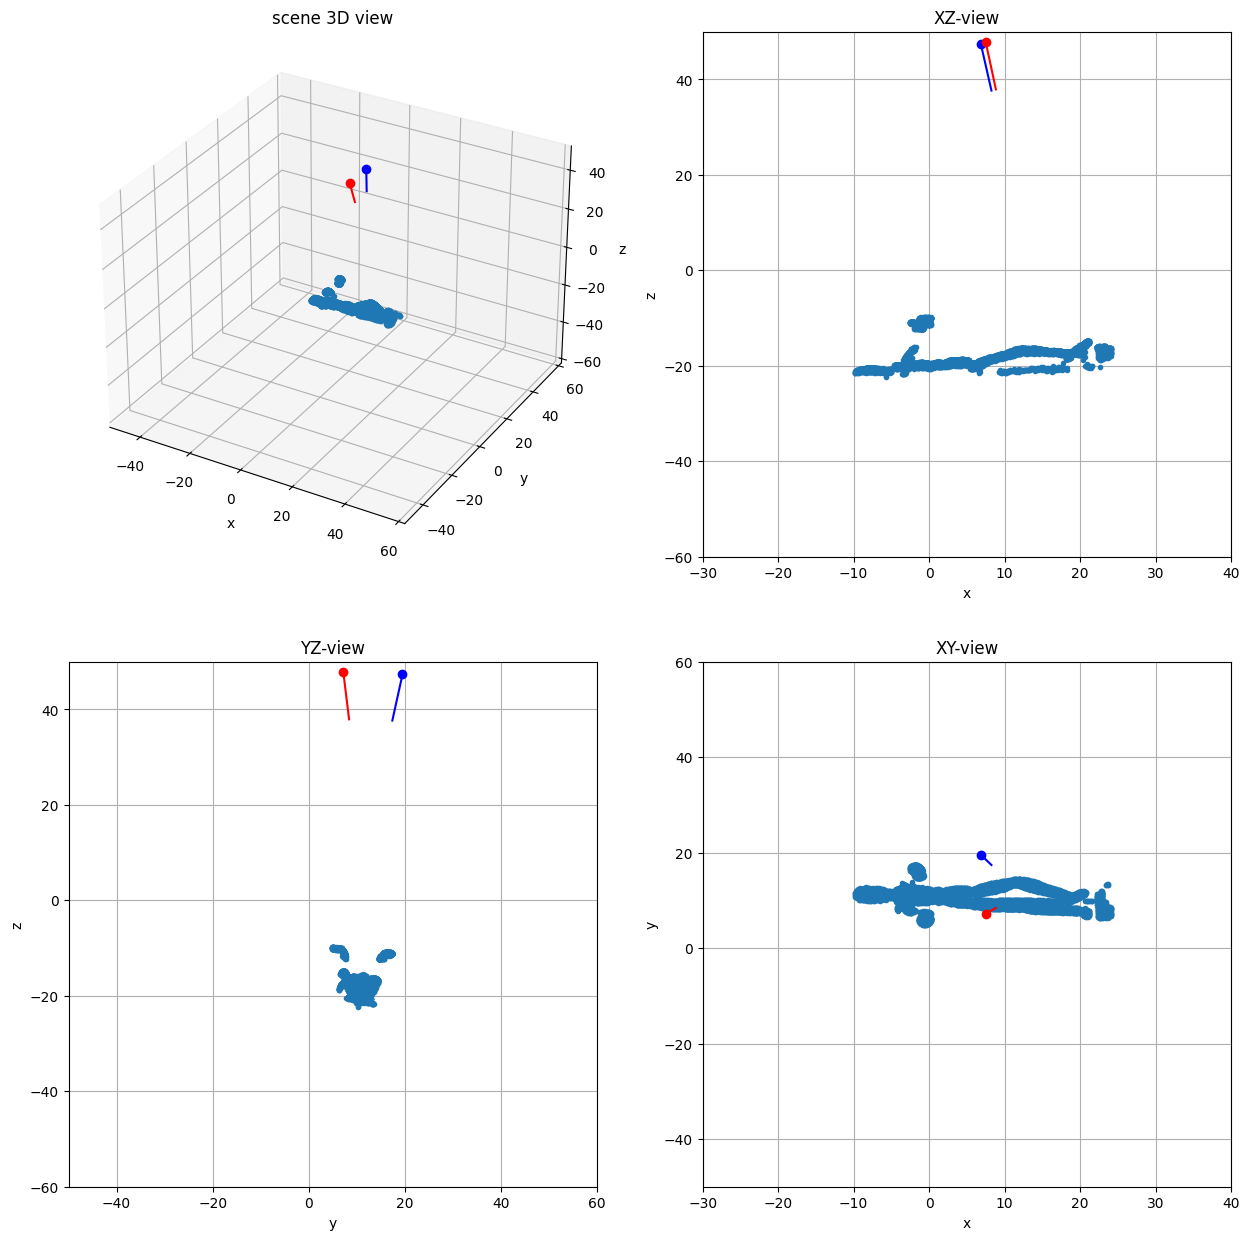

In [6]:
path = "manny/grab_0_u/"

pts2L,pts2R,pts3, color = reconstruct(path, 0.05, camL, camR)

# Bounding box 
min0, max0 = np.min(pts3[0]), np.max(pts3[0])
min1, max1 = np.min(pts3[1]), np.max(pts3[1])
min2, max2 = np.min(pts3[2]), np.max(pts3[2])

print([min0, max0, min1, max1, min2, max2])
# [-9.829567226336227, 24.143979340800136, 
#  4.894100699586025, 17.435736999919456, 
#  -22.261571095874654, -9.791679361183018]
viewlimits = [-30, 40, -50, 60, -60, 50]

showPerspective(camL, camR, pts2L, pts2R, pts3, viewlimits)

In [7]:
def triangle_prune(path, camL, camR, trithresh):
    pts2L, pts2R, pts3, color = reconstruct(path, 0.05, camL, camR)
    
    # No need for using bounding box, because manny is already masked in reconstruct()
    
    # triangle pruning
    tri = scipy.spatial.Delaunay(pts2L.T)
    
    def create_trithresh_mask(pts3, simplices, index1, index2):
        # sqrt((x0 - x1)^2 + (y0 - y1)^2)
        length = np.sqrt(np.sum(np.power(pts3[:, simplices[:, index1]] - 
                                         pts3[:, simplices[:, index2]], 2),
                                axis=0))
        return length < trithresh
    
    mask3 = create_trithresh_mask(pts3, tri.simplices, 0, 1)
    mask4 = create_trithresh_mask(pts3, tri.simplices, 1, 2)
    mask5 = create_trithresh_mask(pts3, tri.simplices, 0, 2)
    
    simplices_mask = np.logical_and(mask3, np.logical_and(mask4, mask5))
    simplices = tri.simplices[simplices_mask]
    
    simplices_index = np.unique(simplices.flatten())
    tri_mask = np.zeros((pts3.shape[1]), np.bool8)
    tri_mask[simplices_index] = True
        
    final_pts3 = pts3[:, tri_mask]
    final_pts2L = pts2L[:, tri_mask]
    final_pts2R = pts2R[:, tri_mask]
    final_color = color[:, tri_mask]
    
    # re-calculate the simplices, old point index -> new index
    final_simplices = np.empty(simplices.shape)
    for i in range(final_simplices.shape[0]):
        final_simplices[i][0] = np.where(simplices_index == simplices[i][0])[0][0]
        final_simplices[i][1] = np.where(simplices_index == simplices[i][1])[0][0]
        final_simplices[i][2] = np.where(simplices_index == simplices[i][2])[0][0]
    final_simplices = final_simplices.astype("uint")
    
    return final_pts3, final_pts2L, final_pts2R, final_simplices, final_color

In [8]:
# testing
path = "manny/grab_0_u/"

final_pts3, final_pts2L, final_pts2R, final_simplices, final_color = triangle_prune(
    path, camL, camR, 8.5)

mesh = trimesh.Trimesh(vertices=final_pts3.T,faces=final_simplices[:,[0,2,1]])
mesh.show()

In [9]:
# http://paulbourke.net/dataformats/ply/
def saveToPly(pts3, faces, color, ofile):
    with open(ofile,"w") as f:
        f.write(f"ply\n")
        f.write(f"format ascii 1.0\n")
        f.write(f"element vertex {pts3.shape[1]}\n")
        f.write(f"property float x\n")
        f.write(f"property float y\n")
        f.write(f"property float z\n")
        f.write(f"property uchar red\n")
        f.write(f"property uchar green\n")
        f.write(f"property uchar blue\n")
        f.write(f"element face {faces.shape[0]}\n")
        f.write(f"property list uchar int vertex_indices\n")
        f.write(f"end_header\n")
        
        # scale color
        color = (255 * color).astype('uint8')

        for i in range(pts3.shape[1]):
            x, y, z = pts3[:, i]
            r, g, b = color[:, i]
            f.write(f"{x:.4f} {y:.4f} {z:.4f} {r} {g} {b}\n")

        for i in range(faces.shape[0]):
            f.write(f"3 {faces[i, 1]:d} {faces[i, 0]:d} {faces[i, 2]:d}\n")

In [10]:
# saveToPly(final_pts3, final_simplices, final_color, "manny-1.ply")

In [11]:
for i in range(5):
    path = f"manny/grab_{i}_u/"
    
    final_pts3, final_pts2L, final_pts2R, final_simplices, final_color = triangle_prune(path, camL, camR, 8.5)
    
    saveToPly(final_pts3, final_simplices, final_color, f"manny{i}.ply")